## Import Required Packages

In [ ]:
#install libraries

!rm -r kdg
!git clone https://github.com/neurodata/kdg
!ls
!pip install kdg/.

In [ ]:
# import modules
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from matplotlib.ticker import ScalarFormatter

from kdg.kdn import *
from kdg.utils import *

## Prepare dataset (Gaussian 2D Parity)

In [ ]:
# Define the experimental setup.
# We will be using a Gaussian sparse parity setup
# You can change these parameters.

n_train = 2000
n_test = 1000

#XOR
X1, y1 = generate_gaussian_parity(n_train)
X1_test, y1_test = generate_gaussian_parity(n_test)

#XNOR
X2, y2 = generate_gaussian_parity(n_train)
X2_test, y2_test = generate_gaussian_parity(n_test)

y2 = -1*(y2-1)
y2_test = -1*(y2_test-1)

## Raw Neural Network

In [ ]:
# Define our neural network parameters

def getNN(dense_size, input_size, **kwargs):
    network_base = keras.Sequential()
    network_base.add(layers.Dense(dense_size, activation='relu', input_shape=(input_size,)))
    network_base.add(layers.Dense(dense_size, activation='relu'))
    network_base.add(layers.Dense(units=2, activation = 'softmax'))
    network_base.compile(**kwargs)
    return network_base

dense_layer_nodes = 5

# NN params
compile_kwargs = {
    "loss": "binary_crossentropy",
    "optimizer": keras.optimizers.Adam(3e-4),
}
fit_kwargs = {"epochs": 150, "batch_size": 32, "verbose": False}


# Fit two neural networks using our test data and print accuracy
nn1 = getNN(dense_layer_nodes, 2, **compile_kwargs)
nn1.fit(X1, keras.utils.to_categorical(y1), **fit_kwargs)
y1_hat = np.argmax(nn1.predict(X1_test), axis=1)

print(f"NN1 Accuracy: {np.mean(y1_hat == y1_test)}")

nn2 = getNN(dense_layer_nodes, 2, **compile_kwargs)
nn2.fit(X2, keras.utils.to_categorical(y2), **fit_kwargs)
y2_hat = np.argmax(nn2.predict(X2_test), axis=1)

print(f"NN2 Accuracy: {np.mean(y2_hat == y2_test)}")

y2_mismatch = np.argmax(nn1.predict(X2_test), axis=1)
print(f"NN1 Accuracy on X2 data: {np.mean(y2_mismatch == y2_test)}")

#Well that's garbage. Let's see if we can do better.

NN1 Accuracy: 0.958
NN2 Accuracy: 0.958
NN1 Accuracy on X2 data: 0.036


## Kernel Density Network Forward Transfer


### Test Functions

In [ ]:
def forward_transfer(X, y, last_means, last_covs,
                     label_polytopes = False):
    r"""
    Re-assign labels, sizes to previous polytopes based on current data

    Parameters:
    -----------
    X: ndarray
        Input data matrix; training data for current task
    y : ndarray
        Output (i.e. response) data matrix for current task
    last_means: ndarray
        Means for previous polytopes
    last_covs: ndarray
        Covariances for previous polytopes

    Returns:
    ----------
    polytope_sizes : new sample counts for polytopes
    polytope_labels : new labels for polytopes
    """

    X = check_array(X)
    labels = np.unique(y)

    #likelihood = X_ members by nPolytopes
    likelihood = []

    # Edited from _compute_pdf
    # Get likelihoods for each pdf
    for polytope_idx in range(last_means.shape[0]):
        polytope_mean = last_means[polytope_idx]
        polytope_cov = last_covs[polytope_idx]

        var = multivariate_normal(
            mean=polytope_mean, cov=polytope_cov, allow_singular=True
        )
        
        likelihood.append(var.pdf(X))

    likelihood = np.array(likelihood)
    proba = np.argmax(likelihood, axis=0)
    proba_by_label = [proba[y == L] for L in labels]

    polytope_counts = np.zeros((labels.shape[0], last_means.shape[0]))
    for label in labels:
        polytope_idxs = np.unique(proba_by_label[label])
        for count, idx in enumerate(polytope_idxs):
            polytope_counts[label, idx] = np.sum(proba_by_label[label] == idx)
    
    if label_polytopes:
        polytope_sizes = np.max(polytope_counts, axis = 0)
        polytope_labels = np.argmax(polytope_counts, axis = 0)
        return polytope_sizes, polytope_labels

    else:
        polytope_sizes = polytope_counts
        return polytope_sizes


In [ ]:
#Some KDN functions externalized for easier testing/editing
def _compute_pdf(X, polytope_id, polytope_means, polytope_covs):
    r"""compute the likelihood for the given data
    Parameters
    ----------
    X : ndarray
        Input data matrix
    label : int
        class label
    polytope_idx : int
        polytope identifier
    Returns
    -------
    ndarray
        likelihoods
    """
    polytope_mean = polytope_means[polytope_id]
    polytope_cov = polytope_covs[polytope_id]

    var = multivariate_normal(
        mean=polytope_mean, cov=polytope_cov, allow_singular=True
    )

    likelihood = var.pdf(X)
    return likelihood

def predict_proba2(X,
                   polytope_means,
                   polytope_covs,
                   polytope_sizes,
                   priors,
                   return_likelihoods=False):
    r"""
    Calculate posteriors using the kernel density network.
    Parameters
    ----------
    X : ndarray
        Input data matrix.
    """
    X = check_array(X)

    labels = np.arange(0, polytope_sizes.shape[0])

    likelihoods = np.zeros((np.size(X, 0), len(labels)), dtype=float)
    priors = np.reshape(priors, (len(priors), 1))

    for label in labels:
        for polytope, size in enumerate(polytope_sizes[label, :]):
            likelihoods[:, label] += np.nan_to_num(
                size * _compute_pdf(X, polytope, polytope_means, polytope_covs)
            )

    proba = (
        likelihoods.T * priors / (np.sum(likelihoods.T * priors, axis=0) + 1e-100)
    ).T
    if return_likelihoods:
        return proba, likelihoods
    else:
        return proba

In [ ]:
# Helper functions for testing

# Add noise to other shapes besides Gaussian sparse parity
def add_noise(X, p = 20, center_box = (-1.0, 1.0)):
    shape = X.shape

    X_noise = np.random.uniform(
        low=center_box[0], high=center_box[1], size=(X.shape[0], p - X.shape[1])
    )
    X = np.concatenate((X, X_noise), axis=1)

    return X

def test_forward_transfer(X, y, kdn, X_test = None, y_test = None,
                          verbose = True, return_summary = True):
    if X_test is None: X_test = X
    if y_test is None: y_test = y

    #flatten polytope information
    means = np.concatenate([val for (key, val) in kdn.polytope_means.items()])
    covs = np.concatenate([val for (key, val) in kdn.polytope_covs.items()])
    #labels_by_task = np.concatenate([np.ones(len(val))*key for (key, val) in kdn.polytope_means.items()])

    #test
    #sizes, labels = forward_transfer(X, y, means, covs)
    sizes = forward_transfer(X, y, means, covs)

    priors = []
    for label in np.unique(y_test):
        priors.append(np.sum(y_test == label))
    priors = priors/np.sum(priors)

    raw = kdn.predict_proba(X_test)
    transfer = predict_proba2(X_test, means, covs, sizes, priors)

    if return_summary:
        raw_m = np.mean(np.argmax(raw, axis = 1) == y_test)
        transfer_m = np.mean(np.argmax(transfer, axis = 1) == y_test)

        if verbose:
            print(f"NN Accuracy on Task 2 data without transfer: {raw_m}")
            print(f"NN Accuracy on Task 2 data after forward transfer: {transfer_m}")
        return raw_m, transfer_m

    else:
        if verbose:
            print(f"Returning posteriors.")
        return raw, transfer

def plot_accuracy(sample_size, pct_errs, labels):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    color_list = [(1.0, 0.0, 0.0), (0.0, 0.0, 0.0)]
    color_list.extend(sns.color_palette("Set1")[1:])

    for i, err in enumerate(pct_errs):
        ax.plot(sample_size, np.mean(err, axis=1), c=color_list[i], label=labels[i])
        ax.fill_between(
            sample_size,
            np.quantile(err, 0.25, axis=1),
            np.quantile(err, 0.75, axis=1),
            facecolor=color_list[i],
            alpha=0.3,
        )
    
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)

    ax.set_xscale("log")
    ax.set_xlabel("Sample size")
    ax.set_ylabel("Percent Error")
    ax.legend(frameon=False)

### Test Algorithm

In [ ]:
#Get initial KDN
kdn1 = kdn(network=nn1)
kdn1.fit(X1, y1)

#Test on new data
test_forward_transfer(X2, y2, kdn1)

NN Accuracy on Task 2 data without transfer: 0.0395
NN Accuracy on Task 2 data after forward transfer: 0.9615


(0.0395, 0.9615)

In [ ]:
#Test fitting to ellipse

X3, y3 = generate_ellipse(n_test)

#Try again
test_forward_transfer(X3, y3, kdn1)

NN Accuracy on Task 2 data without transfer: 0.496
NN Accuracy on Task 2 data after forward transfer: 0.642


(0.496, 0.642)

## Experiments

### XNOR Test

Testing with 100 samples
Task2 KDN Accuracy: [0.76, 0.76, 0.82, 0.67, 0.78, 0.76, 0.62, 0.73, 0.71, 0.74]
Task1 Accuracy on Task 2: [0.07, 0.09, 0.07, 0.08, 0.03, 0.06, 0.06, 0.07, 0.04, 0.04]
Forward Transfer Accuracy on Task 2: [0.83, 0.88, 0.88, 0.76, 0.82, 0.86, 0.8, 0.86, 0.85, 0.85]
Testing with 200 samples
Task2 KDN Accuracy: [0.76, 0.73, 0.78, 0.835, 0.76, 0.765, 0.835, 0.795, 0.855, 0.795]
Task1 Accuracy on Task 2: [0.055, 0.065, 0.065, 0.065, 0.045, 0.06, 0.07, 0.05, 0.05, 0.055]
Forward Transfer Accuracy on Task 2: [0.86, 0.865, 0.86, 0.87, 0.8, 0.825, 0.89, 0.89, 0.91, 0.885]
Testing with 300 samples
Task2 KDN Accuracy: [0.8433333333333334, 0.8466666666666667, 0.8766666666666667, 0.9033333333333333, 0.7966666666666666, 0.8, 0.8566666666666667, 0.8366666666666667, 0.7766666666666666, 0.8733333333333333]
Task1 Accuracy on Task 2: [0.043333333333333335, 0.03666666666666667, 0.04666666666666667, 0.06333333333333334, 0.05, 0.06333333333333334, 0.05333333333333334, 0.043333333333

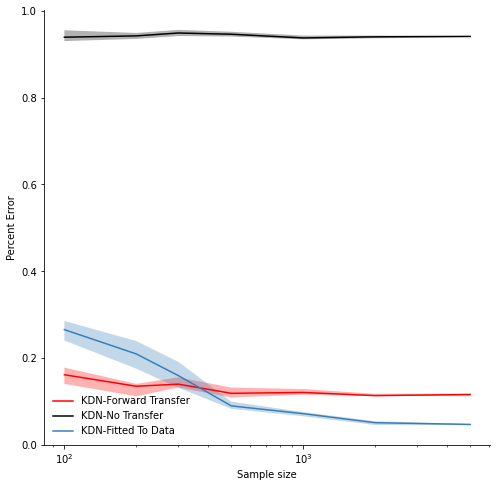

In [ ]:
accuracy_task1 = []
accuracy_forward = []
accuracy_kdn = []

p = 10
p_star = 2
sample_size = [100, 200, 300, 500, 1000, 2000, 5000]
reps = 10

test_size = min(sample_size)

# Run tests

X1, y1 = gaussian_sparse_parity(500, p_star = p_star, p = p)
raw_nn = getNN(dense_layer_nodes, p, **compile_kwargs)
raw_nn.fit(X1, keras.utils.to_categorical(y1), **fit_kwargs)
kdn_task1 = kdn(network = raw_nn, verbose=False)
kdn_task1.fit(X1, y1)

for s in sample_size:
    print(f"Testing with {s} samples")
    for r in range(reps):
        #XNOR
        X_train, y_train = gaussian_sparse_parity(s, p_star = p_star, p = p)
        X_test, y_test = gaussian_sparse_parity(s, p_star=p_star, p=p)
        
        y_train = -1*(y_train-1)
        y_test = -1*(y_test-1)

        #Original KDN to serve as a baseline
        nn_test = getNN(dense_layer_nodes, p, **compile_kwargs)
        nn_test.fit(X_train, keras.utils.to_categorical(y_train), **fit_kwargs)
        kdn_test = kdn(network = nn_test)
        kdn_test.fit(X_train, y_train)
        accuracy_kdn.append(np.mean(kdn_test.predict(X_test) == y_test))

        #Task1 KDN with Forward Transfer
        raw, forward = test_forward_transfer(X_train,
                                             y_train,
                                             kdn_task1,
                                             X_test = X_test,
                                             y_test = y_test,
                                             verbose = False)
        accuracy_task1.append(raw)
        accuracy_forward.append(forward)


    print("Task2 KDN Accuracy:", accuracy_kdn[-reps:])
    print("Task1 Accuracy on Task 2:", accuracy_task1[-reps:])
    print("Forward Transfer Accuracy on Task 2:", accuracy_forward[-reps:])

# Plot results
shape = (len(sample_size), reps)
err_kdn = 1 - np.array(accuracy_kdn).reshape(shape)
err_task1 = 1 - np.array(accuracy_task1).reshape(shape)
err_forward = 1 - np.array(accuracy_forward).reshape(shape)

error_rates = (err_forward, err_task1, err_kdn)
labels = ("KDN-Forward Transfer", "KDN-No Transfer", "KDN-Fitted To Data")

plot_accuracy(sample_size, error_rates, labels)

### 45-Degree XOR

Testing with 100 samples
Task2 KDN Accuracy: [0.94, 0.93, 0.97, 0.94, 0.92, 0.98, 0.97, 0.96, 0.98, 0.93]
Task1 Accuracy on Task 2: [0.55, 0.55, 0.5, 0.52, 0.52, 0.6, 0.52, 0.54, 0.48, 0.56]
Forward Transfer Accuracy on Task 2: [0.96, 0.95, 0.96, 0.92, 0.93, 0.97, 0.97, 0.97, 0.98, 0.93]
Testing with 200 samples
Task2 KDN Accuracy: [0.95, 0.95, 0.95, 0.95, 0.93, 0.94, 0.94, 0.96, 0.975, 0.945]
Task1 Accuracy on Task 2: [0.52, 0.525, 0.51, 0.52, 0.545, 0.52, 0.58, 0.54, 0.45, 0.52]
Forward Transfer Accuracy on Task 2: [0.94, 0.97, 0.965, 0.945, 0.93, 0.95, 0.93, 0.95, 0.965, 0.94]
Testing with 300 samples
Task2 KDN Accuracy: [0.9433333333333334, 0.9666666666666667, 0.9633333333333334, 0.9566666666666667, 0.94, 0.9466666666666667, 0.9366666666666666, 0.9466666666666667, 0.9533333333333334, 0.97]
Task1 Accuracy on Task 2: [0.49333333333333335, 0.5266666666666666, 0.5166666666666667, 0.5366666666666666, 0.5133333333333333, 0.5133333333333333, 0.49333333333333335, 0.5066666666666667, 0.5633

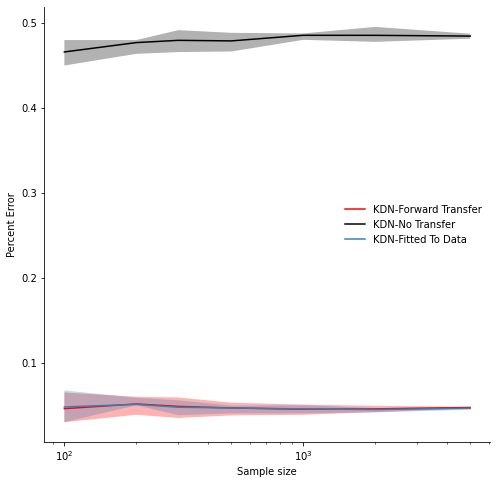

In [ ]:
accuracy_task1 = []
accuracy_forward = []
accuracy_kdn = []

#p = 10
#p_star = 2
sample_size = [100, 200, 300, 500, 1000, 2000, 5000]
reps = 10

test_size = min(sample_size)

# Run tests

#X1, y1 = gaussian_sparse_parity(500, p_star = p_star, p = p)
X1, y1 =  generate_gaussian_parity(500)
raw_nn = getNN(dense_layer_nodes, 2, **compile_kwargs)
raw_nn.fit(X1, keras.utils.to_categorical(y1), **fit_kwargs)
kdn_task1 = kdn(network = raw_nn, verbose=False)
kdn_task1.fit(X1, y1)

for s in sample_size:
    print(f"Testing with {s} samples")
    for r in range(reps):
        #XNOR
        X_train, y_train = generate_gaussian_parity(s, angle_params = np.pi/4)
        X_test, y_test = generate_gaussian_parity(s, angle_params = np.pi/4)

        #X_train = add_noise(X_train, p)
        #X_test = add_noise(X_test, p)

        #Original KDN to serve as a baseline
        nn_test = getNN(dense_layer_nodes, 2, **compile_kwargs)
        nn_test.fit(X_train, keras.utils.to_categorical(y_train), **fit_kwargs)
        kdn_test = kdn(network = nn_test)
        kdn_test.fit(X_train, y_train)
        accuracy_kdn.append(np.mean(kdn_test.predict(X_test) == y_test))

        #Task1 KDN with Forward Transfer
        raw, forward = test_forward_transfer(X_train,
                                             y_train,
                                             kdn_task1,
                                             X_test = X_test,
                                             y_test = y_test,
                                             verbose = False,
                                             return_summary = True)
        accuracy_task1.append(raw)
        accuracy_forward.append(forward)


    print("Task2 KDN Accuracy:", accuracy_kdn[-reps:])
    print("Task1 Accuracy on Task 2:", accuracy_task1[-reps:])
    print("Forward Transfer Accuracy on Task 2:", accuracy_forward[-reps:])

# Plot results
shape = (len(sample_size), reps)
err_kdn = 1 - np.array(accuracy_kdn).reshape(shape)
err_task1 = 1 - np.array(accuracy_task1).reshape(shape)
err_forward = 1 - np.array(accuracy_forward).reshape(shape)

error_rates = (err_forward, err_task1, err_kdn)
labels = ("KDN-Forward Transfer", "KDN-No Transfer", "KDN-Fitted To Data")

plot_accuracy(sample_size, error_rates, labels)

### Ellipse Test

Testing with 500 samples
Task2 KDN Accuracy: [0.578, 0.578, 0.606, 0.622, 0.602, 0.6, 0.574, 0.54, 0.534, 0.55]
Task1 Accuracy on Task 2: [0.488, 0.5, 0.508, 0.548, 0.508, 0.508, 0.516, 0.508, 0.508, 0.504]
Forward Transfer Accuracy on Task 2: [0.63, 0.634, 0.63, 0.644, 0.612, 0.638, 0.642, 0.592, 0.64, 0.556]
Testing with 1000 samples
Task2 KDN Accuracy: [0.606, 0.593, 0.619, 0.614, 0.6, 0.587, 0.619, 0.58, 0.655, 0.622]
Task1 Accuracy on Task 2: [0.508, 0.492, 0.527, 0.509, 0.518, 0.521, 0.491, 0.499, 0.485, 0.495]
Forward Transfer Accuracy on Task 2: [0.666, 0.656, 0.64, 0.663, 0.606, 0.633, 0.616, 0.618, 0.652, 0.645]
Testing with 2500 samples
Task2 KDN Accuracy: [0.656, 0.6408, 0.762, 0.704, 0.6548, 0.6972, 0.7272, 0.74, 0.6388, 0.6948]
Task1 Accuracy on Task 2: [0.4916, 0.49, 0.5172, 0.4836, 0.4812, 0.5188, 0.4976, 0.5048, 0.4876, 0.498]
Forward Transfer Accuracy on Task 2: [0.6572, 0.6672, 0.6472, 0.6488, 0.65, 0.6728, 0.6596, 0.632, 0.6504, 0.6732]
Testing with 5000 samples
Tas

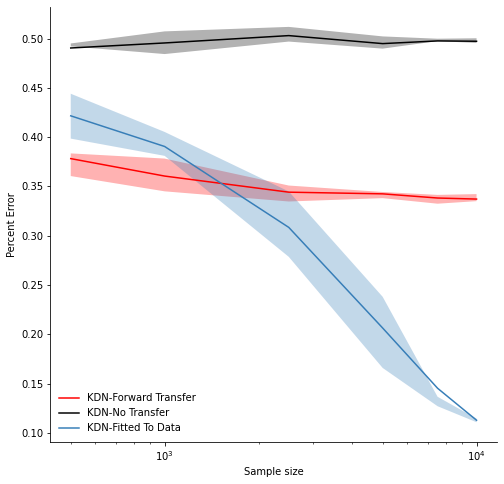

In [ ]:
accuracy_task1 = []
accuracy_forward = []
accuracy_kdn = []

p = 10
p_star = 2
sample_size = [500, 1000, 2500, 5000, 7500, 10000]
reps = 10

test_size = min(sample_size)

# Run tests

X1, y1 = gaussian_sparse_parity(5000, p_star = p_star, p = p)
raw_nn = getNN(dense_layer_nodes, p, **compile_kwargs)
raw_nn.fit(X1, keras.utils.to_categorical(y1), **fit_kwargs)
kdn_task1 = kdn(network = raw_nn, verbose=False)
kdn_task1.fit(X1, y1)

for s in sample_size:
    print(f"Testing with {s} samples")
    for r in range(reps):
        #XNOR
        X_train, y_train = generate_ellipse(s)
        X_test, y_test = generate_ellipse(s)

        X_train = add_noise(X_train, p)
        X_test = add_noise(X_test, p)

        #Original KDN to serve as a baseline
        nn_test = getNN(dense_layer_nodes, p, **compile_kwargs)
        nn_test.fit(X_train, keras.utils.to_categorical(y_train), **fit_kwargs)
        kdn_test = kdn(network = nn_test)
        kdn_test.fit(X_train, y_train)
        accuracy_kdn.append(np.mean(kdn_test.predict(X_test) == y_test))

        #Task1 KDN with Forward Transfer
        raw, forward = test_forward_transfer(X_train,
                                             y_train,
                                             kdn_task1,
                                             X_test = X_test,
                                             y_test = y_test,
                                             verbose = False)
        accuracy_task1.append(raw)
        accuracy_forward.append(forward)


    print("Task2 KDN Accuracy:", accuracy_kdn[-reps:])
    print("Task1 Accuracy on Task 2:", accuracy_task1[-reps:])
    print("Forward Transfer Accuracy on Task 2:", accuracy_forward[-reps:])

# Plot results
shape = (len(sample_size), reps)
err_kdn = 1 - np.array(accuracy_kdn).reshape(shape)
err_task1 = 1 - np.array(accuracy_task1).reshape(shape)
err_forward = 1 - np.array(accuracy_forward).reshape(shape)

error_rates = (err_forward, err_task1, err_kdn)
labels = ("KDN-Forward Transfer", "KDN-No Transfer", "KDN-Fitted To Data")

plot_accuracy(sample_size, error_rates, labels)

### Visualize Posteriors

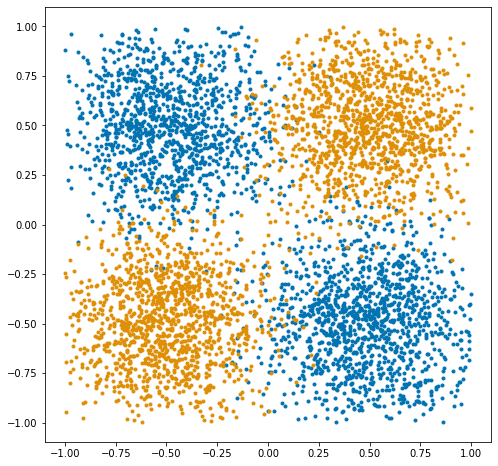

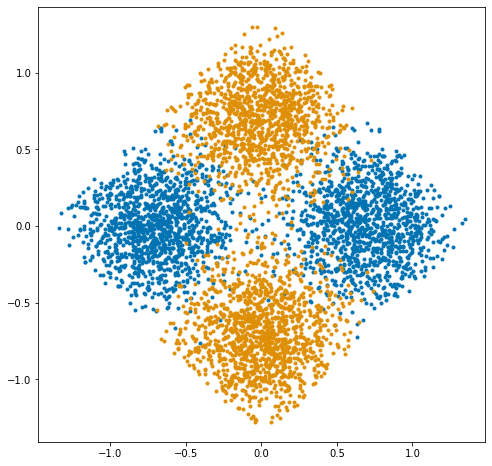

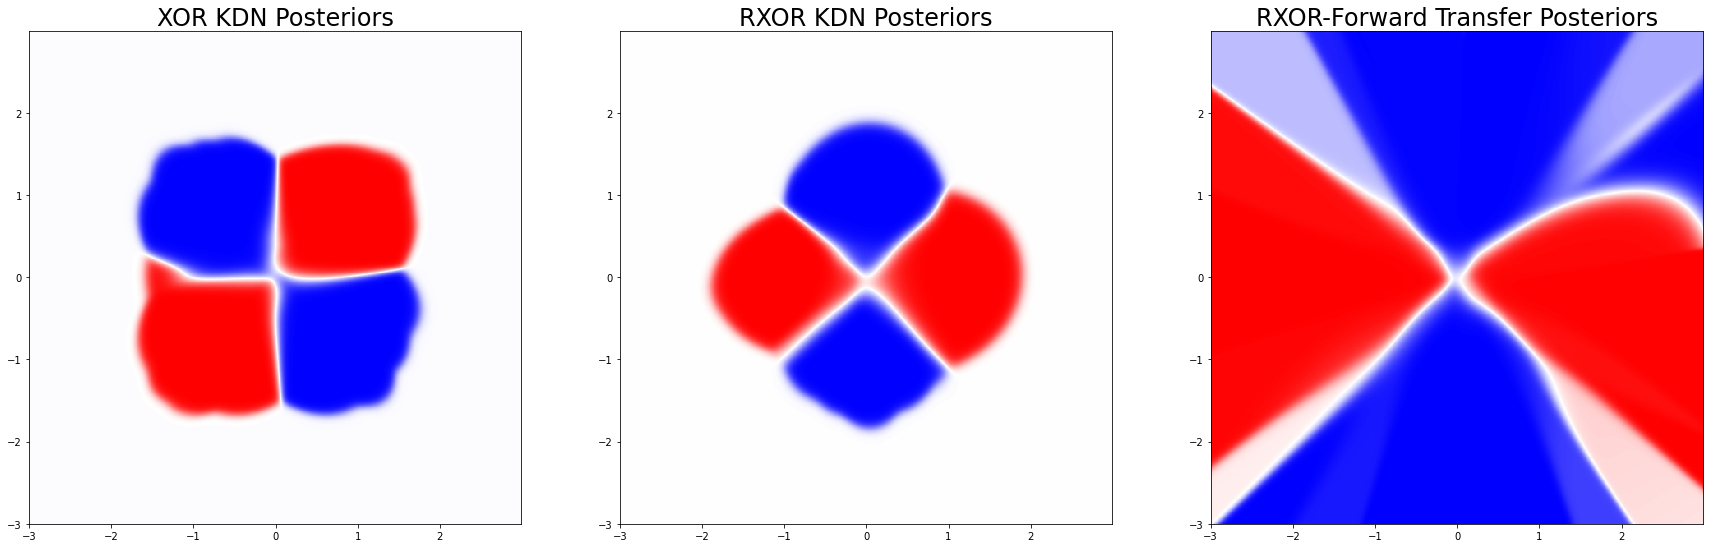

In [ ]:
X1, y1 = generate_gaussian_parity(5000)
plot_2dsim(X1, y1)

X2, y2 = generate_gaussian_parity(5000, angle_params = np.pi/4)
plot_2dsim(X2, y2)

# Get KDNs
nn1 = getNN(5, 2, **compile_kwargs)
nn1.fit(X1, keras.utils.to_categorical(y1), **fit_kwargs)
kdn_task1 = kdn(network = nn1, verbose=False)
kdn_task1.fit(X1, y1)

nn2 = getNN(5, 2, **compile_kwargs)
nn2.fit(X1, keras.utils.to_categorical(y1), **fit_kwargs)
kdn_task2 = kdn(network = nn2, verbose=False)
kdn_task2.fit(X2, y2)

#define grids
p = np.arange(-3, 3, step=0.01)
q = np.arange(-3, 3, step=0.01)
xx, yy = np.meshgrid(p, q)
grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

posterior_task1 = kdn_task1.predict_proba(grid_samples)
posterior_task2 = kdn_task2.predict_proba(grid_samples)
_, posterior_ft = test_forward_transfer(X2, y2,
                                        kdn_task1,
                                        X_test = grid_samples,
                                        verbose = False,
                                        return_summary = False)

posterior_task1 = posterior_task1[:,0].reshape(600,600)
posterior_task2 = posterior_task2[:,0].reshape(600,600)
posterior_ft = posterior_ft[:,0].reshape(600,600)

fig1, ax = plt.subplots(1, 3, figsize=(30, 90))

ax0 = ax[0].imshow(
    posterior_task1,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("XOR KDN Posteriors", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    posterior_task2,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("RXOR KDN Posteriors", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    posterior_ft,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("RXOR-Forward Transfer Posteriors", fontsize=24)
ax[2].set_aspect("equal")
plt.show()